In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore',category=UserWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
import W2V3
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student1/sushovan.saha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
glove_path = 'glove.6B.100d.txt'

In [3]:
X_head_train,X_body_train,y_train = W2V3.Sentence2Vec(filename='Train.xlsx',glovepath=glove_path, embedding_dim=100, max_length=120)

number of word in vocabulary 21678
word in sentences are replaced with word ID [[    0     0     0 ...    83  3352   403]
 [    0     0     0 ...   244  5664    30]
 [    0     0     0 ...  4939    70  3962]
 ...
 [    0     0     0 ...   420  8176 21678]
 [    0     0     0 ...   397   264  1499]
 [    0     0     0 ...    47   435     1]]
The size of vocabulary  21679
Loaded 400000 word vectors.
(26590, 120, 100)
number of word in vocabulary 143699
word in sentences are replaced with word ID [[   3    2   24 ...    9  114 1996]
 [9796  590 2684 ...   61 1065 3100]
 [1958 2002 7091 ... 7257 2133 1951]
 ...
 [   2  900   94 ...  156  882   19]
 [   2   58 1794 ...   57   47   84]
 [3262 3233 4319 ...  472  382 2286]]
The size of vocabulary  143700
Loaded 400000 word vectors.
(26590, 120, 100)


In [4]:
X_head_test,X_body_test,y_test = W2V3.Sentence2Vec(filename='Test.xlsx',glovepath=glove_path, embedding_dim=100, max_length=120)

number of word in vocabulary 4343
word in sentences are replaced with word ID [[   0    0    0 ...    7 1623  645]
 [   0    0    0 ...   87 1626  646]
 [   0    0    0 ...  179  202  647]
 ...
 [   0    0    0 ...  147 4339   29]
 [   0    0    0 ... 4342 4343 1261]
 [   0    0    0 ...  125   22 1619]]
The size of vocabulary  4344
Loaded 400000 word vectors.
(1300, 120, 100)
number of word in vocabulary 37490
word in sentences are replaced with word ID [[   15  2444  1170 ...  6866  6867   292]
 [ 1849  1254 17674 ... 10294   477   271]
 [   66  3773   922 ...   352  1242    17]
 ...
 [  252   610  3654 ...  2282  1443   403]
 [   36    49    73 ...  4708   219   997]
 [  452   312   956 ...    12   394     6]]
The size of vocabulary  37491
Loaded 400000 word vectors.
(1300, 120, 100)


In [5]:
print(X_head_test.shape)
print(X_body_test.shape)

(1300, 120, 100)
(1300, 120, 100)


In [6]:
len(X_body_test)

1300

In [7]:
pd.Series(y_train).value_counts()

2    10241
0     8861
1     7488
dtype: int64

In [8]:
pd.Series(y_test).value_counts()

2    599
0    402
1    299
dtype: int64

In [9]:
max_length = X_body_train.shape[1]

In [10]:
from torch.autograd import Variable
class myLSTM(nn.Module):

    def __init__(self, dimension, hidd_dim):
        super().__init__()
        self.hidd_dim = hidd_dim
        self.lstm = nn.LSTM(input_size=dimension,
        hidden_size=self.hidd_dim,
        num_layers=2,
        batch_first=True,
        bidirectional=False)
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(4*hidd_dim, 3)
        self.act = nn.Softmax()



    def forward(self, head,body, batch_size):
        np.random.seed(1)
        h_0_head = Variable(torch.rand(2, batch_size, self.hidd_dim))
        c_0_head = Variable(torch.rand(2, batch_size, self.hidd_dim))
        h_0_body = Variable(torch.rand(2, batch_size, self.hidd_dim))
        c_0_body = Variable(torch.rand(2, batch_size, self.hidd_dim))
        head, (final_hidden_state_head, final_cell_state_head) = self.lstm(head, (h_0_head, c_0_head))
        body, (final_hidden_state_body, final_cell_state_body) = self.lstm(body, (h_0_body, c_0_body))
        h = final_hidden_state_head[-1]
        b = final_hidden_state_body[-1]
        x = torch.cat((h,b,h-b,h+b), dim=1)
        x = self.fc(x)
        #x = self.act(x)
        return x


            

In [11]:
def train(model, head,body, y, loss_fn, optimizer, batch_size=1024):
    model.train()
    head,body, y = torch.Tensor(head),torch.Tensor(head), torch.Tensor(y)
    y = y.type(torch.LongTensor)
    net_loss = 0
    
    for i in range(0, len(head), batch_size):
        i_end = i+batch_size
        head_batch = head[i:min(i_end, len(head))]
        body_batch = body[i:min(i_end, len(body))]
        y_batch = y[i:min(i_end, len(head))]
        
        pred = model(head_batch,body_batch,head_batch.shape[0])
        loss = loss_fn(pred, y_batch)
        net_loss = net_loss+loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return net_loss

def test(model, head,body, yts,batchsize):
    model.eval()
    with torch.no_grad():
        head = torch.Tensor(head)
        body = torch.Tensor(body)
        pred = model(head,body,batchsize)
        loss = loss_fn(pred, torch.Tensor(yts).type(torch.LongTensor))
        yhat = np.argmax(pred, axis=1).numpy()
        acc = np.sum(yhat==yts)*100/yhat.shape[0]
        f1 = metrics.f1_score(yts,yhat,average=None)
        return acc, f1,loss

In [12]:
model = myLSTM(X_body_train.shape[2], hidd_dim=100)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
batch_size = 512
epochs = 70
train_loss = []
test_acc = []
train_acc = []
test_loss = []

for i in range(epochs):
    print("--- Epoch {} ---".format(i+1))
    epoch_loss = train(model,X_head_train, X_body_train, y_train, loss_fn, optimizer, batch_size)
    train_loss.append(epoch_loss)
    print("\tCross Entropy Loss (Training) : {} ".format(epoch_loss))

    acc, _, __ = test(model, X_head_train, X_body_train, y_train, batchsize=X_body_train.shape[0])
    print("\tTrain Accuracy : {:.2f} % ".format(acc))
    train_acc.append(acc)
    
    acc, _, tst_loss = test(model, X_head_test, X_body_test, y_test, batchsize=X_body_test.shape[0])
    print("\tTest Accuracy : {:.2f} % ".format(acc))
    test_acc.append(acc)
    test_loss.append(tst_loss)


--- Epoch 1 ---
	Cross Entropy Loss (Training) : 55.033864855766296 
	Train Accuracy : 38.76 % 
	Test Accuracy : 45.92 % 
--- Epoch 2 ---
	Cross Entropy Loss (Training) : 52.32769864797592 
	Train Accuracy : 39.61 % 
	Test Accuracy : 45.69 % 
--- Epoch 3 ---
	Cross Entropy Loss (Training) : 51.042550563812256 
	Train Accuracy : 40.22 % 
	Test Accuracy : 45.15 % 
--- Epoch 4 ---
	Cross Entropy Loss (Training) : 50.022927939891815 
	Train Accuracy : 39.55 % 
	Test Accuracy : 45.62 % 
--- Epoch 5 ---
	Cross Entropy Loss (Training) : 49.01375538110733 
	Train Accuracy : 39.42 % 
	Test Accuracy : 45.62 % 
--- Epoch 6 ---
	Cross Entropy Loss (Training) : 48.0782744884491 
	Train Accuracy : 39.47 % 
	Test Accuracy : 45.62 % 
--- Epoch 7 ---
	Cross Entropy Loss (Training) : 47.14399856328964 
	Train Accuracy : 40.03 % 
	Test Accuracy : 45.69 % 
--- Epoch 8 ---
	Cross Entropy Loss (Training) : 46.18229204416275 
	Train Accuracy : 39.89 % 
	Test Accuracy : 45.54 % 
--- Epoch 9 ---
	Cross Entropy

	Cross Entropy Loss (Training) : 1.8549319114536047 
	Train Accuracy : 55.74 % 
	Test Accuracy : 44.00 % 
--- Epoch 69 ---
	Cross Entropy Loss (Training) : 1.6556598842144012 
	Train Accuracy : 58.26 % 
	Test Accuracy : 42.31 % 
--- Epoch 70 ---
	Cross Entropy Loss (Training) : 1.287065902724862 
	Train Accuracy : 59.43 % 
	Test Accuracy : 41.92 % 


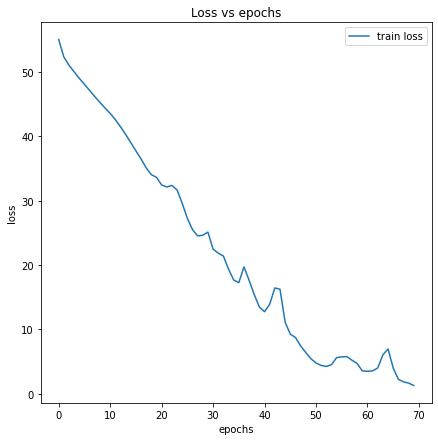

In [13]:
plt.figure(figsize=(7,7))
plt.plot(range(epochs), train_loss, label="train loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss vs epochs")
plt.legend(loc="best")
plt.show()

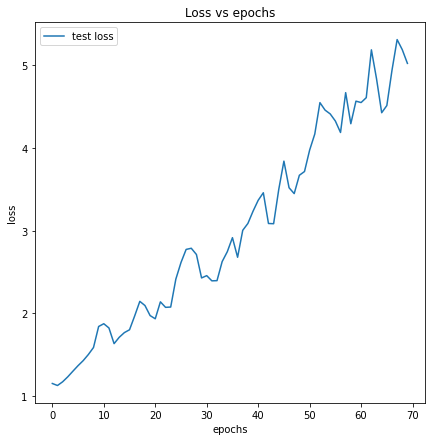

In [14]:
plt.figure(figsize=(7,7))
plt.plot(range(epochs), test_loss, label="test loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss vs epochs")
plt.legend(loc="best")
plt.show()

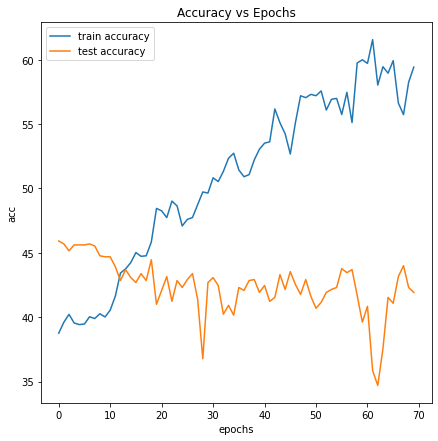

In [15]:
plt.figure(figsize=(7,7))
plt.plot(range(epochs), train_acc, label="train accuracy")
plt.plot(range(epochs), test_acc, label="test accuracy")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.title("Accuracy vs Epochs")
plt.legend(loc="best")
plt.show()

In [16]:
acc, f1, _ = test(model, X_head_test,X_body_test, y_test, batchsize=X_body_test.shape[0])
print("Test Accuracy : {:.2f} % ".format(acc))
print("Test Class-wise F1 Score : \n{}".format(f1))

Test Accuracy : 42.54 % 
Test Class-wise F1 Score : 
[0.26453488 0.21171171 0.5653951 ]
